In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import lightgbm as lgb
from tqdm import tqdm_notebook
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
# 加载训练和测试数据集

train_transaction = pd.read_csv("train_transaction.csv")
print("train_transaction shape : ", train_transaction.shape)

train_identity = pd.read_csv("train_identity.csv")
print("train_identity shape : ", train_identity.shape)

test_transaction = pd.read_csv("test_transaction.csv")
print("test_transaction shape : ", test_transaction.shape)

test_identity = pd.read_csv("test_identity.csv")
print("test_identity shape : ", test_identity.shape)

train_transaction shape :  (590540, 394)
train_identity shape :  (144233, 41)
test_transaction shape :  (506691, 393)
test_identity shape :  (141907, 41)
CPU times: user 18.4 s, sys: 1.17 s, total: 19.6 s
Wall time: 19.6 s


In [3]:
# 默认显示前5行
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 查看数据信息
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
# 查看数据描述
train_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [6]:
# 统计数据中的NaN
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [7]:
# 默认显示前5行
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
# 数据信息
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [9]:
# 数据描述
train_identity.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [10]:
# 统计NaN
train_identity.isnull().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   TransactionID  144233 non-null  bool 
 1   id_01          144233 non-null  bool 
 2   id_02          144233 non-null  bool 
 3   id_03          144233 non-null  bool 
 4   id_04          144233 non-null  bool 
 5   id_05          144233 non-null  bool 
 6   id_06          144233 non-null  bool 
 7   id_07          144233 non-null  bool 
 8   id_08          144233 non-null  bool 
 9   id_09          144233 non-null  bool 
 10  id_10          144233 non-null  bool 
 11  id_11          144233 non-null  bool 
 12  id_12          144233 non-null  bool 
 13  id_13          144233 non-null  bool 
 14  id_14          144233 non-null  bool 
 15  id_15          144233 non-null  bool 
 16  id_16          144233 non-null  bool 
 17  id_17          144233 non-null  bool 
 18  id_18          144233 no

In [11]:
# test transaction 数据默认显示
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [13]:
test_transaction.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,...,76431.000000,7.643100e+04,7.643100e+04,7.643100e+04,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412,87.065270,...,0.309900,3.151286e+02,4.404643e+02,3.811021e+02,24.708030,58.339468,35.485643,99.058760,155.578153,139.814706
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328,314.131694,...,2.632181,9.494045e+03,1.064843e+04,1.039556e+04,842.913287,990.361078,904.093921,2436.074522,4544.303974,4493.728267
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.000000,150.000000,166.000000,204.000000,87.000000,3.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.916894e+06,2.720466e+07,67.950000,9803.000000,369.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.000000,150.000000,226.000000,330.000000,87.000000,20.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.170239e+06,3.421434e+07,10270.000000,18397.000000,600.000000,232.000000,237.000000,540.000000,102.000000,8081.000000,...,106.000000,1.040658e+06,1.040658e+06,1.040658e+06,64800.000000,64800.000000,64800.000000,375000.000000,612500.000000,612500.000000


In [14]:
test_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id-01          141907 non-null  float64
 2   id-02          136976 non-null  float64
 3   id-03          66481 non-null   float64
 4   id-04          66481 non-null   float64
 5   id-05          134750 non-null  float64
 6   id-06          134750 non-null  float64
 7   id-07          5059 non-null    float64
 8   id-08          5059 non-null    float64
 9   id-09          74338 non-null   float64
 10  id-10          74338 non-null   float64
 11  id-11          136778 non-null  float64
 12  id-12          141907 non-null  object 
 13  id-13          130286 non-null  float64
 14  id-14          71357 non-null   float64
 15  id-15          136977 non-null  object 
 16  id-16          125747 non-null  object 
 17  id-17          135966 non-nul

In [15]:
test_identity.describe()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,1.419070e+05,141907.000000,136976.000000,66481.000000,66481.000000,134750.000000,134750.000000,5059.000000,5059.000000,74338.000000,...,135966.000000,50875.000000,135906.000000,135633.000000,5059.000000,5062.000000,4740.000000,5039.000000,5047.000000,70671.000000
mean,3.972166e+06,-11.325734,192658.729909,0.053008,-0.087454,1.246033,-6.803829,12.493180,-36.577782,0.076219,...,191.070341,14.795735,350.122982,408.886230,507.727021,15.336823,13.166667,332.043064,152.752923,26.217939
std,1.469966e+05,14.508520,182613.277215,0.684551,0.840351,5.071394,15.921457,11.678206,25.544185,1.009687,...,30.749535,2.318496,139.140824,158.971756,227.371061,5.618032,3.222440,86.356683,31.916995,3.601046
min,3.663586e+06,-100.000000,2.000000,-12.000000,-19.000000,-81.000000,-100.000000,-41.000000,-100.000000,-32.000000,...,100.000000,11.000000,100.000000,100.000000,100.000000,11.000000,10.000000,100.000000,100.000000,8.000000
25%,3.859268e+06,-12.500000,63339.500000,0.000000,0.000000,0.000000,-6.000000,3.000000,-46.000000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,137.000000,24.000000
50%,4.001774e+06,-5.000000,133189.500000,0.000000,0.000000,0.000000,0.000000,12.000000,-33.000000,0.000000,...,166.000000,15.000000,321.000000,484.000000,576.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,4.105284e+06,-5.000000,265717.500000,0.000000,0.000000,1.000000,0.000000,21.000000,-23.000000,0.000000,...,225.000000,15.000000,427.000000,549.000000,711.000000,14.000000,15.000000,355.000000,182.000000,32.000000
max,4.170239e+06,0.000000,999869.000000,11.000000,0.000000,52.000000,0.000000,59.000000,0.000000,16.000000,...,228.000000,29.000000,670.000000,660.000000,854.000000,44.000000,26.000000,549.000000,216.000000,48.000000


In [16]:
test_identity.isnull().sum()

TransactionID         0
id-01                 0
id-02              4931
id-03             75426
id-04             75426
id-05              7157
id-06              7157
id-07            136848
id-08            136848
id-09             67569
id-10             67569
id-11              5129
id-12                 0
id-13             11621
id-14             70550
id-15              4930
id-16             16160
id-17              5941
id-18             91032
id-19              6001
id-20              6274
id-21            136848
id-22            136845
id-23            136845
id-24            137167
id-25            136868
id-26            136860
id-27            136845
id-28              5129
id-29              5129
id-30             71248
id-31              5282
id-32             71236
id-33             71236
id-34             69732
id-35              4930
id-36              4930
id-37              4930
id-38              4930
DeviceType         4976
DeviceInfo        26850
dtype: int64

### 根据 TransactionID 合并 train_transaction 和 train_identity，test_transaction 和 test_identity

In [17]:
# 根据以上数据的shape，可以发现，并非所有的transaction都有相关联的identity
# 计算一下占比
train_count = np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID']))
print("train_transaction与train_identity基于TransactionID相关联的数据量 : ", train_count)

train_ratio = train_count / len(train_transaction)
print("相关联数据量占整个train_transaction数据量的比例是 : {:.2f}%".format(train_ratio * 100))

train_transaction与train_identity基于TransactionID相关联的数据量 :  144233
相关联数据量占整个train_transaction数据量的比例是 : 24.42%


In [18]:
test_count = np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID']))
print("test_transaction与test_identity基于TransactionID相关联的数据量 : ", test_count)

test_ratio = test_count / len(test_transaction)
print("相关联数据量占整个test_transaction数据量的比例是 : {:.2f}%".format(test_ratio * 100))

test_transaction与test_identity基于TransactionID相关联的数据量 :  141907
相关联数据量占整个test_transaction数据量的比例是 : 28.01%


In [19]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [20]:
train.shape

(590540, 434)

In [21]:
test.shape

(506691, 433)

### 数据集EDA（数据探索分析）

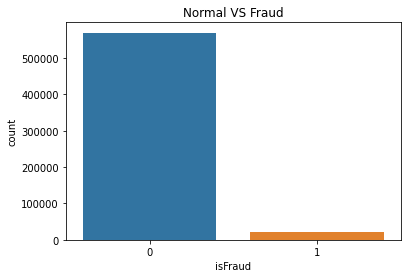

In [22]:
# 在train_transaction中，正负样本比例
sns.countplot('isFraud', data=train)
plt.title("Normal VS Fraud")
plt.show()

<AxesSubplot:title={'center':'Distribution of Transaction Amount'}, ylabel='Frequency'>

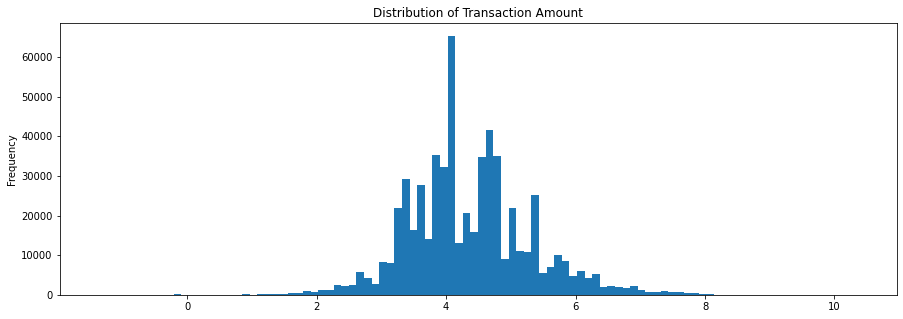

In [23]:
# 交易金额分布
train['TransactionAmt'].apply(np.log).plot(kind='hist', bins=100, figsize=(15, 5), title='Distribution of Transaction Amount')

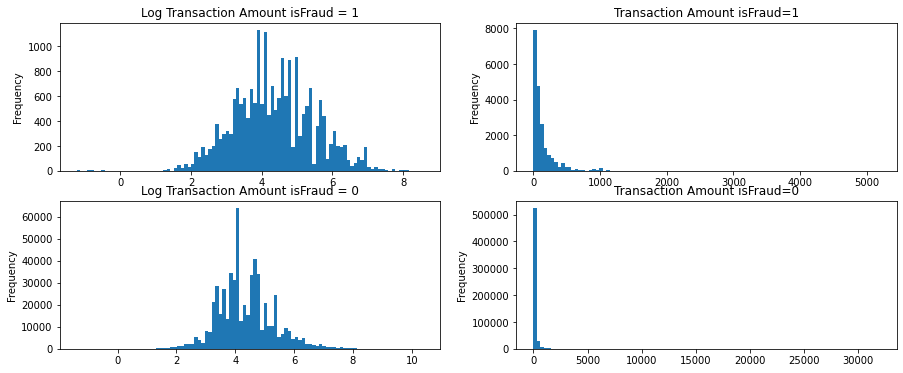

In [24]:
# 交易金额（正常 vs 欺诈）分布
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6)) # 画布大小

train.loc[train['isFraud']==1]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                    bins=100,
                                                                    title='Log Transaction Amount isFraud = 1',
                                                                    ax=ax1)

train.loc[train['isFraud']==1]['TransactionAmt'].plot(kind='hist',
                                                      bins=100,
                                                      title='Transaction Amount isFraud=1',
                                                      ax=ax2)

train.loc[train['isFraud']==0]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                    bins=100,
                                                                    title='Log Transaction Amount isFraud = 0',
                                                                    ax=ax3)

train.loc[train['isFraud']==0]['TransactionAmt'].plot(kind='hist',
                                                      bins=100,
                                                      title='Transaction Amount isFraud=0',
                                                      ax=ax4)

plt.show()

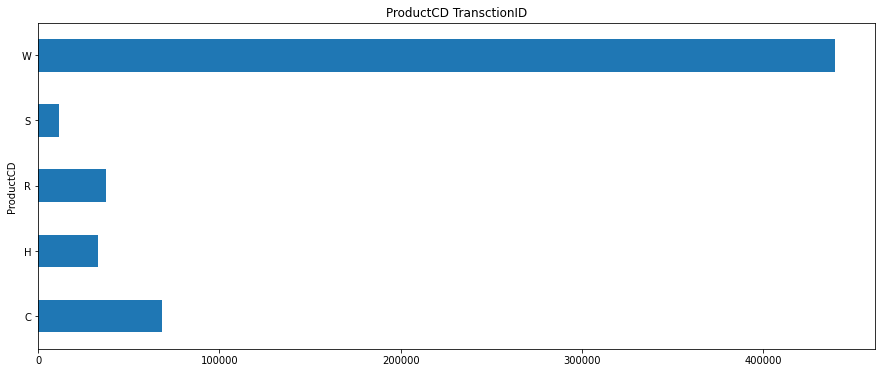

In [25]:
# 分析 ProductCD
train.groupby('ProductCD')['TransactionID'].count().plot(kind='barh',
                                                         figsize=(15, 6),
                                                         title='ProductCD TransctionID')
plt.show()

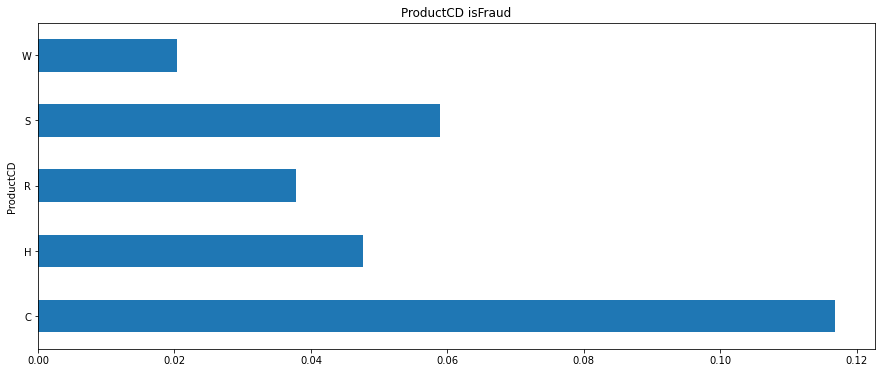

In [26]:
 train.groupby('ProductCD')['isFraud'].mean().plot(kind='barh',
                                                         figsize=(15, 6),
                                                         title='ProductCD isFraud')
plt.show()

### # 分类变量进行转换 LabelEncoder

In [27]:
# 输出 object 类型的列
for col in train.columns:
    if train[col].dtype == "object":
        print(col)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


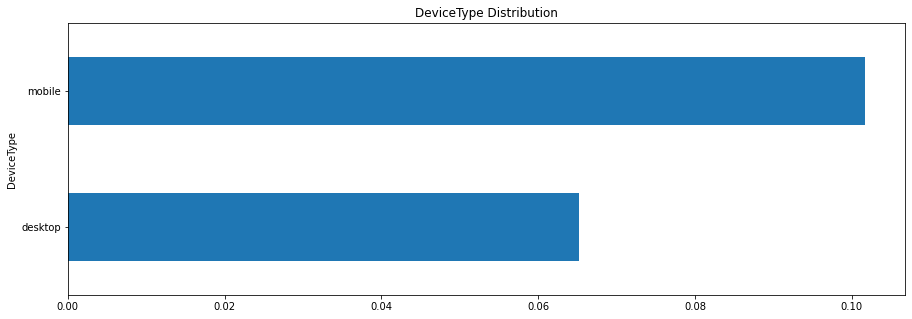

In [28]:
# 输出 DeviceType 的分布
train.groupby("DeviceType").mean()["isFraud"].plot(kind='barh',
                                        figsize=(15, 5),
                                        title = "DeviceType Distribution")
plt.show()

In [29]:
# 统计每一列的NaN的数量，如果比例超过70%，则删除该列
def clean_nan(df):
    temp_columns = []
    for col in df.columns:
        # 获取一列
        counter = df[col].isnull().sum()
        # 占该列的比例
        ratio = counter / len(df[col])
        if ratio > 0.7:
            # 删除该列
            temp_columns.append(col)

    # 删除那些列
    new_df = df.drop(temp_columns, axis=1)
    return new_df

In [30]:
print("原始的train shape : ", train.shape)
train = clean_nan(train)
print("清洗后的train shape : ", train.shape)

原始的train shape :  (590540, 434)
清洗后的train shape :  (590540, 226)


In [31]:
print("原始的test shape : ", test.shape)
test = clean_nan(test)
print("清洗后的test shape : ", test.shape)

原始的test shape :  (506691, 433)
清洗后的test shape :  (506691, 225)


In [32]:
def clean_top_cols(df):
    new_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return new_cols

In [33]:
train_cols = clean_top_cols(train)

In [34]:
test_cols = clean_top_cols(test)

In [35]:
len(train_cols)

55

In [36]:
len(test_cols)

69

In [37]:
cols_to_drop = list(set(train_cols + test_cols))

In [38]:
len(cols_to_drop)

71

In [39]:
'isFraud' in cols_to_drop # 查看标签列是否在其中

True

In [40]:
cols_to_drop.remove('isFraud') # 删除标签列

In [41]:
# 清理掉这些列
print("原始的train shape : ", train.shape)
train = train.drop(cols_to_drop, axis=1)
print("清理后的train shape : ", train.shape)

原始的train shape :  (590540, 226)
清理后的train shape :  (590540, 156)


In [42]:
# 清理掉这些列
print("原始的test shape : ", test.shape)
test = test.drop(cols_to_drop, axis=1)
print("清理后的test shape : ", test.shape)

原始的test shape :  (506691, 225)
清理后的test shape :  (506691, 155)


In [43]:
for col in train.columns:
    if col not in test.columns:
        print(col)

isFraud


In [44]:
# LabelEncoder

for col in tqdm_notebook(train.columns):
    if train[col].dtype == "object":
        encoder = LabelEncoder()
        encoder.fit(list(train[col].values) + list(test[col].values))
        train[col] = encoder.transform(list(train[col].values))
        test[col] = encoder.transform(list(test[col].values))
        
train = train.reset_index() # 重置索引
test = test.reset_index()

In [45]:
train.shape

(590540, 157)

In [46]:
test.shape

(506691, 156)

In [47]:
# 分离数据集和标签

X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)

y = train.sort_values('TransactionDT')['isFraud']

In [48]:
X.shape

(590540, 154)

In [49]:
y.shape

(590540,)

In [50]:
# test

X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1) # 删除多余的列，不是特征

test = test[['TransactionDT', 'TransactionID']]

In [51]:
X_test.shape

(506691, 154)

In [52]:
test.shape

(506691, 2)

In [53]:
# params 超参数设置

params = {'num_leaves': 491, # 叶节点数量
          'min_data_in_leaf': 106, # 每个叶子节点中的数据
          'objective': 'binary', # 任务：二分类
          'max_depth': -1, # -1 ： 不限制深度
          "boosting_type": "gbdt", # 'dart', 'goss', 'rf'
          "metric": 'auc', # 衡量标准
          "verbosity" : -1, # 不显示信息
          'random_state': 66, # 随机种子
         }

In [54]:
# 创建DataFrame保存特征重要性
feature_importances = pd.DataFrame(index=None)

feature_importances['features'] = X.columns

In [55]:
feature_importances

,features
0,index
1,TransactionAmt
2,ProductCD
3,card1
4,card2
...,...
149,V312
150,V313
151,V314
152,V315


In [56]:
# 5折交叉验证
folds = KFold(n_splits=5)

splits = folds.split(X, y) # 分割成5份，前4份是训练集索引，最后1份是验证集索引

In [57]:
next(iter(splits)) # 输出的是索引

(array([118108, 118109, 118110, ..., 590537, 590538, 590539]),
 array([     0,      1,      2, ..., 118105, 118106, 118107]))

In [58]:
best_auc = 0
best_model = None

for k, (train_indices, val_indices) in enumerate(splits):
    print("第 %d 折\n" % k)
    X_train_data, X_val_data = X.iloc[train_indices], X.iloc[val_indices] # 训练集， 验证集
    y_train, y_val = y.iloc[train_indices], y.iloc[val_indices] # 训练标签，验证标签
    #print("X_train_data shape : \t", X_train_data.shape, "X_val_data shape : \t", X_val_data.shape)
    
    train_dataset = lgb.Dataset(X_train_data, label=y_train) # 训练集
    val_dataset = lgb.Dataset(X_val_data, label=y_val) # 验证集
    
    lgb_model = lgb.train(params=params, # 超参数设置
                          train_set=train_dataset, # 训练数据
                          num_boost_round=10000, # 循环的轮数
                          valid_sets=val_dataset, # 验证数据
                          valid_names='validation', # 验证集名称
                          early_stopping_rounds=200,) # 如果200轮后没有提升，就停止循环
    # 保存特征重要性
    feature_importances[f'fold_{k+1}'] = lgb_model.feature_importance()
    
    # 对验证集进行预测
    y_val_pred = lgb_model.predict(X_val_data)
    
    # 计算roc_auc
    roc_auc = roc_auc_score(y_val, y_val_pred)
    print(f" Fold {k + 1} | AUC_ROC ： { roc_auc * 100}%")
    
    # 判断是否是最优模型
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_model = lgb_model

第 0 折

[1]	validation's auc: 0.837964
Training until validation scores don't improve for 200 rounds
[2]	validation's auc: 0.857038
[3]	validation's auc: 0.874131
[4]	validation's auc: 0.87959
[5]	validation's auc: 0.881985
[6]	validation's auc: 0.88422
[7]	validation's auc: 0.885251
[8]	validation's auc: 0.887934
[9]	validation's auc: 0.889501
[10]	validation's auc: 0.892001
[11]	validation's auc: 0.895664
[12]	validation's auc: 0.897139
[13]	validation's auc: 0.897977
[14]	validation's auc: 0.898092
[15]	validation's auc: 0.898943
[16]	validation's auc: 0.899843
[17]	validation's auc: 0.901197
[18]	validation's auc: 0.905897
[19]	validation's auc: 0.906642
[20]	validation's auc: 0.907274
[21]	validation's auc: 0.909835
[22]	validation's auc: 0.909991
[23]	validation's auc: 0.910338
[24]	validation's auc: 0.910913
[25]	validation's auc: 0.911114
[26]	validation's auc: 0.911657
[27]	validation's auc: 0.911381
[28]	validation's auc: 0.91135
[29]	validation's auc: 0.911215
[30]	validation

[253]	validation's auc: 0.924866
[254]	validation's auc: 0.925046
[255]	validation's auc: 0.925098
[256]	validation's auc: 0.924842
[257]	validation's auc: 0.924678
[258]	validation's auc: 0.924726
[259]	validation's auc: 0.924502
[260]	validation's auc: 0.924542
[261]	validation's auc: 0.924688
[262]	validation's auc: 0.924672
[263]	validation's auc: 0.924771
[264]	validation's auc: 0.924942
[265]	validation's auc: 0.924978
[266]	validation's auc: 0.925011
[267]	validation's auc: 0.924843
[268]	validation's auc: 0.924882
[269]	validation's auc: 0.924833
[270]	validation's auc: 0.924798
[271]	validation's auc: 0.924693
[272]	validation's auc: 0.924766
[273]	validation's auc: 0.924613
[274]	validation's auc: 0.924541
[275]	validation's auc: 0.924426
[276]	validation's auc: 0.924419
[277]	validation's auc: 0.924405
[278]	validation's auc: 0.924381
[279]	validation's auc: 0.924225
[280]	validation's auc: 0.924276
[281]	validation's auc: 0.924273
[282]	validation's auc: 0.924102
[283]	vali

[195]	validation's auc: 0.92166
[196]	validation's auc: 0.921696
[197]	validation's auc: 0.921633
[198]	validation's auc: 0.921602
[199]	validation's auc: 0.921624
[200]	validation's auc: 0.921669
[201]	validation's auc: 0.921665
[202]	validation's auc: 0.921639
[203]	validation's auc: 0.921551
[204]	validation's auc: 0.921675
[205]	validation's auc: 0.921828
[206]	validation's auc: 0.921686
[207]	validation's auc: 0.921465
[208]	validation's auc: 0.92161
[209]	validation's auc: 0.921701
[210]	validation's auc: 0.921726
[211]	validation's auc: 0.921798
[212]	validation's auc: 0.921764
[213]	validation's auc: 0.921788
[214]	validation's auc: 0.921896
[215]	validation's auc: 0.92178
[216]	validation's auc: 0.921753
[217]	validation's auc: 0.921768
[218]	validation's auc: 0.921734
[219]	validation's auc: 0.921758
[220]	validation's auc: 0.921735
[221]	validation's auc: 0.921696
[222]	validation's auc: 0.921667
[223]	validation's auc: 0.921753
[224]	validation's auc: 0.921871
[225]	validat

[178]	validation's auc: 0.940462
[179]	validation's auc: 0.940524
[180]	validation's auc: 0.940535
[181]	validation's auc: 0.940467
[182]	validation's auc: 0.940536
[183]	validation's auc: 0.940525
[184]	validation's auc: 0.940478
[185]	validation's auc: 0.940467
[186]	validation's auc: 0.940418
[187]	validation's auc: 0.940455
[188]	validation's auc: 0.940495
[189]	validation's auc: 0.940464
[190]	validation's auc: 0.940481
[191]	validation's auc: 0.940433
[192]	validation's auc: 0.940364
[193]	validation's auc: 0.940361
[194]	validation's auc: 0.940485
[195]	validation's auc: 0.940364
[196]	validation's auc: 0.940396
[197]	validation's auc: 0.940334
[198]	validation's auc: 0.940307
[199]	validation's auc: 0.940396
[200]	validation's auc: 0.9404
[201]	validation's auc: 0.940513
[202]	validation's auc: 0.940471
[203]	validation's auc: 0.940548
[204]	validation's auc: 0.940506
[205]	validation's auc: 0.940438
[206]	validation's auc: 0.940469
[207]	validation's auc: 0.940502
[208]	valida

[144]	validation's auc: 0.914879
[145]	validation's auc: 0.914869
[146]	validation's auc: 0.915041
[147]	validation's auc: 0.915182
[148]	validation's auc: 0.915218
[149]	validation's auc: 0.91508
[150]	validation's auc: 0.91511
[151]	validation's auc: 0.915103
[152]	validation's auc: 0.915165
[153]	validation's auc: 0.915296
[154]	validation's auc: 0.915149
[155]	validation's auc: 0.915353
[156]	validation's auc: 0.915399
[157]	validation's auc: 0.915274
[158]	validation's auc: 0.91541
[159]	validation's auc: 0.915406
[160]	validation's auc: 0.915525
[161]	validation's auc: 0.915376
[162]	validation's auc: 0.91542
[163]	validation's auc: 0.915307
[164]	validation's auc: 0.915442
[165]	validation's auc: 0.91555
[166]	validation's auc: 0.915603
[167]	validation's auc: 0.915696
[168]	validation's auc: 0.915832
[169]	validation's auc: 0.915877
[170]	validation's auc: 0.915771
[171]	validation's auc: 0.915676
[172]	validation's auc: 0.915803
[173]	validation's auc: 0.916008
[174]	validatio

[396]	validation's auc: 0.917394
[397]	validation's auc: 0.917365
[398]	validation's auc: 0.917257
[399]	validation's auc: 0.917224
[400]	validation's auc: 0.917144
[401]	validation's auc: 0.917324
[402]	validation's auc: 0.917402
[403]	validation's auc: 0.917396
[404]	validation's auc: 0.9173
[405]	validation's auc: 0.917218
[406]	validation's auc: 0.917276
[407]	validation's auc: 0.917245
[408]	validation's auc: 0.917218
[409]	validation's auc: 0.917239
[410]	validation's auc: 0.917435
[411]	validation's auc: 0.917416
[412]	validation's auc: 0.917407
[413]	validation's auc: 0.917313
[414]	validation's auc: 0.917336
[415]	validation's auc: 0.917358
[416]	validation's auc: 0.91724
[417]	validation's auc: 0.91713
[418]	validation's auc: 0.917284
[419]	validation's auc: 0.917204
[420]	validation's auc: 0.917257
[421]	validation's auc: 0.917232
[422]	validation's auc: 0.917229
[423]	validation's auc: 0.917145
[424]	validation's auc: 0.917198
[425]	validation's auc: 0.917212
[426]	validati

In [59]:
feature_importances.shape

(154, 5)

In [60]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4
0,index,5040,2791,3878,24806
1,TransactionAmt,4134,2149,2986,19489
2,ProductCD,197,156,167,829
3,card1,4426,2489,3404,17317
4,card2,3701,2236,2855,13681


In [61]:
feature_importances['average'] = feature_importances[[f'fold_{k+1}' for k in range(folds.n_splits-1)]].mean(axis=1)

In [62]:
feature_importances.head()

,features,fold_1,fold_2,fold_3,fold_4,average
0,index,5040,2791,3878,24806,9128.75
1,TransactionAmt,4134,2149,2986,19489,7189.50
2,ProductCD,197,156,167,829,337.25
3,card1,4426,2489,3404,17317,6909.00
4,card2,3701,2236,2855,13681,5618.25


Text(0.5, 1.0, '50 top features importance over 4 folds average.')

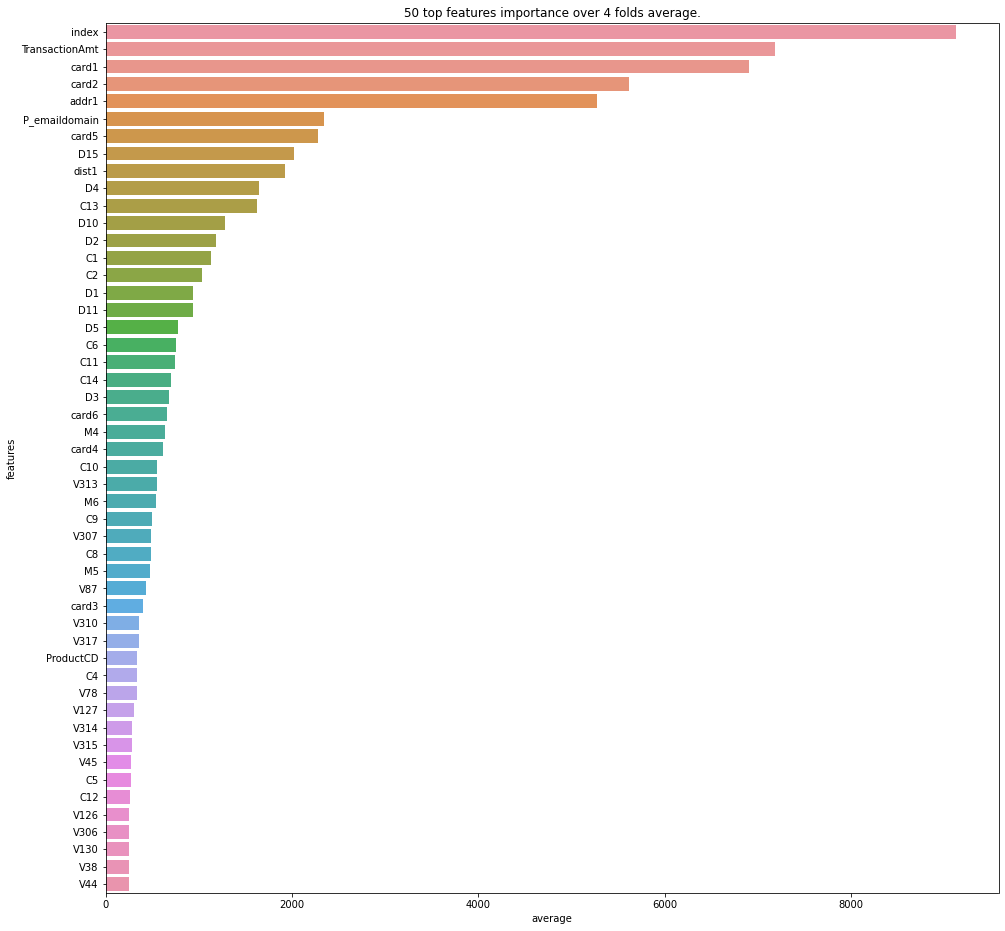

In [63]:
# 可视化显示前50个特征
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), 
            x='average', 
            y='features')
plt.title("50 top features importance over {} folds average.".format(folds.n_splits-1))

In [64]:
print("The best roc_auc : ", roc_auc)

The best roc_auc :  0.9178962789641628


In [65]:
joblib.dump(best_model, "best_model.pkl") # 保存模型

['best_model.pkl']

In [66]:
# 对与test进行预测

y_test_pred = best_model.predict(X_test)

In [67]:
y_test_pred.shape

(506691,)

In [68]:
labels = np.round(y_test_pred) # np.round() 四舍五入

In [69]:
from collections import Counter
nd(y_test_pred) 
Counter(labels)

Counter({0.0: 498364, 1.0: 8327})